# ECON 421 Project 1

## I. Data Preparation

<b>Data Source</b><br>
We collected our data using the official data from Federal Reserve Economic Data(FRED) https://fred.stlouisfed.org. The <b>time period</b> of this dataset is 10 years monthly data from April 2013 to March 2023.  <br><br>
<b>Data Cleaning</b><br>Our data cleaning process contains the following procedure: <br> <b>    1.</b> Calculate the percentage return of S&P 500 data using the formula: (Current Period - Last Period)*100/Last Period<br>
<b>    2.</b> Scynchronize the data to the same frequency and merge data.<br>
<b>    3.</b> Check for NULL values and use linear trend to fill them.<br>
<b>    4.</b> Calculate other needed data (lags and leads data)<br>

In [1]:
import pandas_datareader as pdr
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

In [2]:
## get uneployment rate and sp500 return data
start_date = '2013-04-15'
un_data = pdr.data.DataReader('UNRATE', 'fred', start_date)
T = len(un_data)
index = pd.date_range(start = '2013-04',periods = T,freq = 'M')
un_data.index = index 

sp_data = pdr.data.DataReader('SP500','fred', start_date)
sp_data =sp_data.resample('M').mean()
sp_data['return_rate'] =(sp_data['SP500']/sp_data['SP500'].shift(1)-1)*100

## merge data
ori_data = pd.merge(sp_data, un_data, left_index = True, right_index =True)

In [3]:
ori_data.isnull().sum()

SP500          0
return_rate    1
UNRATE         0
dtype: int64

In [4]:
ori_data.interpolate(method='linear', inplace=True)

In [5]:
## 1 period lead for S&P 500
ori_data['ld1_sp'] = ori_data['SP500'].shift(-1)
## 2 periods lead for S&P 500
ori_data['ld2_sp'] = ori_data['SP500'].shift(-2)
## 3 periods lead for S&P 500
ori_data['ld3_sp'] = ori_data['SP500'].shift(-3)

## 1 period lag for unemployment rate
ori_data['lag1_un'] = ori_data['UNRATE'].shift(1)


In [6]:
ori_data.interpolate(method='linear', inplace=True)

In [7]:
## finish data cleaning. Name ori_data --> data
data = ori_data
data = data.drop(index = '2013-04-30')

In [8]:
data.isnull().sum()

SP500          0
return_rate    0
UNRATE         0
ld1_sp         0
ld2_sp         0
ld3_sp         0
lag1_un        0
dtype: int64

## II. Data Introduction

Unemployment rate is always considered as a lagging indicator for economics. A bullish market might predict low unemployment rate. In order to find the relationship between unemployment rate and stock price, we introduce the following dataset contains <b>unemployment</b> rate, <b>S&P 500</b> index value and its growth rate. The <b>time period</b> of this dataset is 10 years monthly data from April 2013 to March 2023. 

In [9]:
data.head()

,SP500,return_rate,UNRATE,ld1_sp,ld2_sp,ld3_sp,lag1_un
2013-05-31,1639.842727,4.368532,7.5,1618.772500,1668.675455,1670.093636,7.5
2013-06-30,1618.772500,-1.284893,7.3,1668.675455,1670.093636,1687.173500,7.5
2013-07-31,1668.675455,3.082765,7.2,1670.093636,1687.173500,1720.026522,7.3
2013-08-31,1670.093636,0.084988,7.2,1687.173500,1720.026522,1783.541000,7.2
2013-09-30,1687.173500,1.022689,7.2,1720.026522,1783.541000,1807.775238,7.2


In [10]:
data.describe()

,SP500,return_rate,UNRATE,ld1_sp,ld2_sp,ld3_sp,lag1_un
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,2804.610163,0.870227,5.123729,2825.286791,2846.141979,2866.574261,5.157627
std,866.362833,3.356396,1.822306,867.440866,867.768493,868.191609,1.829035
min,1618.772500,-19.068070,3.400000,1618.772500,1668.675455,1670.093636,3.400000
25%,2076.649042,-0.311072,3.800000,2080.146966,2081.011322,2082.619683,3.800000
50%,2658.982869,1.332977,4.750000,2682.917068,2702.133723,2703.964536,4.800000
75%,3385.161667,2.748817,5.875000,3411.953523,3516.419716,3658.730625,5.900000
max,4674.772727,6.338024,14.700000,4674.772727,4674.772727,4674.772727,14.700000


<b> scatter plot</b>

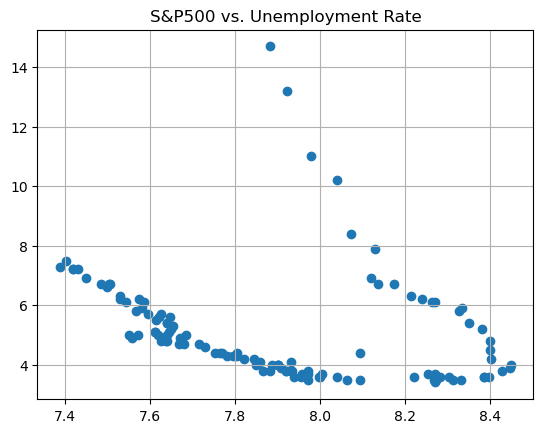

In [11]:
plt.title('S&P500 vs. Unemployment Rate')
plt.scatter(np.log(data['SP500']), data['UNRATE'])
plt.grid()

<b> Outliers <br>

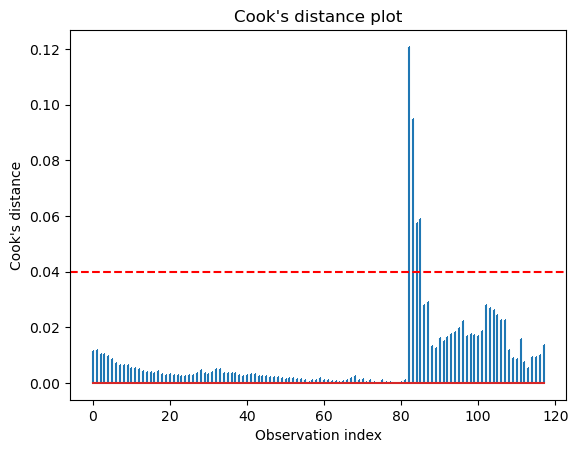

In [12]:
X = np.log(data['UNRATE'])
y = data['SP500']
model = smf.ols('y ~ X', data = data).fit()

# Calculate Cook's distance
influence = model.get_influence()
cook_dist = influence.cooks_distance[0]

# Plot Cook's distance
plt.stem(cook_dist, markerfmt=",")

# Add a horizontal line at the threshold value
plt.axhline(y=0.04, color="r", linestyle="--")

plt.title("Cook's distance plot")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.show()



## III. Results 
### 1. Modeling and Forecasting Trend
#### (a) Time-seires plot and stationarity

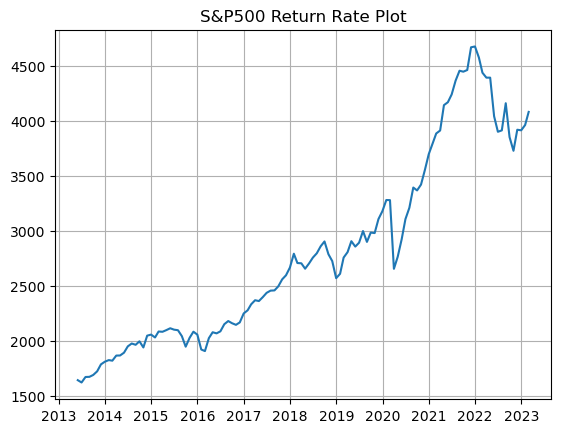

In [13]:
plt.title('S&P500 Return Rate Plot')
plt.plot(data['SP500'])
plt.grid()

In [14]:
from statsmodels.tsa.stattools import adfuller
values = data['return_rate'].values

# Run the ADF test
result = adfuller(values)
result[1]

1.9397854172770823e-13

<b>Illustration:</b> According to ADF test, the dataset is stationary.

#### (c) ACF and PACF

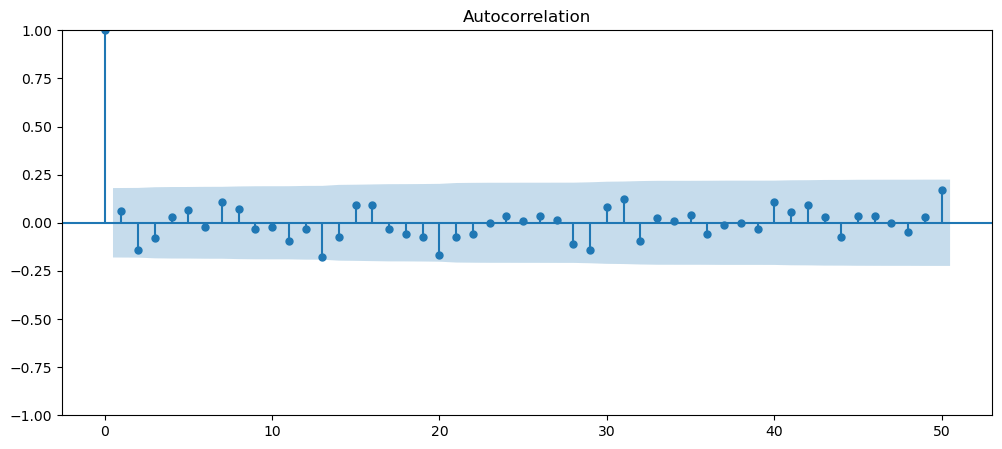

/Users/dwx/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


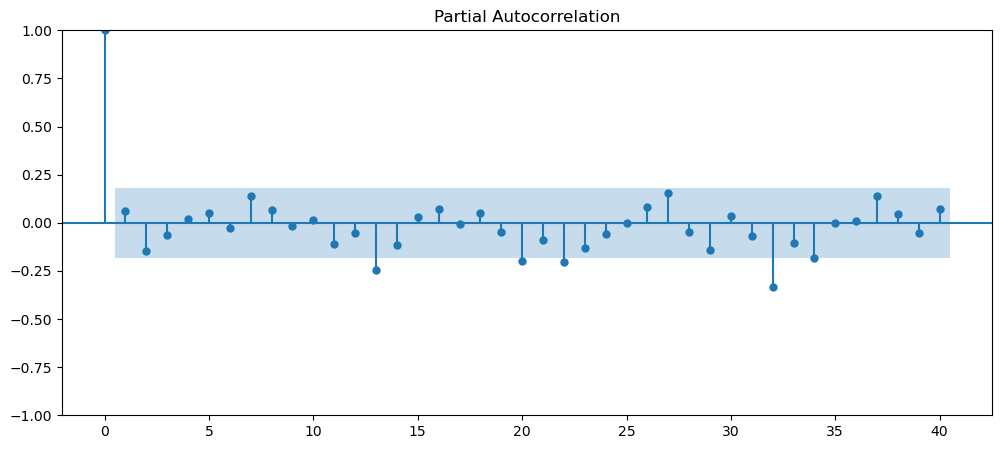

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot the ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(data['return_rate'], lags=50, ax=ax)
plt.show()

# Plot the PACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(data['return_rate'], lags=40, ax=ax)
plt.show()

<b> Illustration</b>
1. There are many autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
2. High degree of autocorrelation between adjacent (lag = 14,32) in PACF plot
3. Seasonality and cycle can be spotted in the plots

#### (c) Linear Model 

In [16]:
X = data['UNRATE']
y = data['SP500']
model1 = smf.ols('y ~ X', data = data).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     8.046
Date:                Mon, 17 Apr 2023   Prob (F-statistic):            0.00538
Time:                        12:30:23   Log-Likelihood:                -961.16
No. Observations:                 118   AIC:                             1926.
Df Residuals:                     116   BIC:                             1932.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3425.0152    232.023     14.762      0.0

<b>Comment: </b><br> 1. R-squared(4.9%) suggest the model is a poor fit. <br>2. The p-value for F-statistic in this model is 0.015, suggesting that this model is strongly statistically significant.<br> 3. P-value for the t-test of the model parameters shows that the model is statistically significant as well.

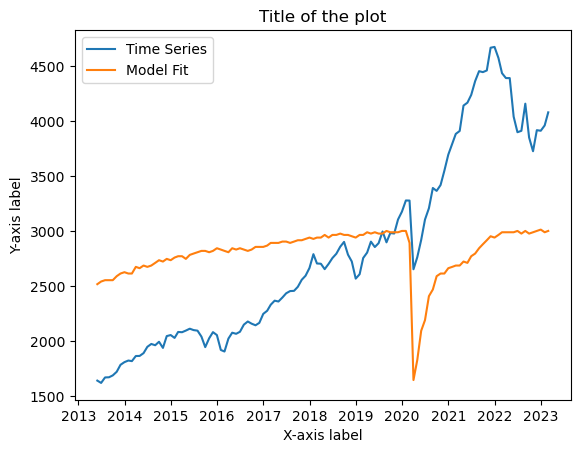

In [17]:
y_fit1 = model1.fittedvalues

fig, ax = plt.subplots()
ax.plot(data.index, data['SP500'], label='Time Series')
ax.plot(data.index, y_fit1, label='Model Fit')
ax.legend()
ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
ax.set_title('Title of the plot')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


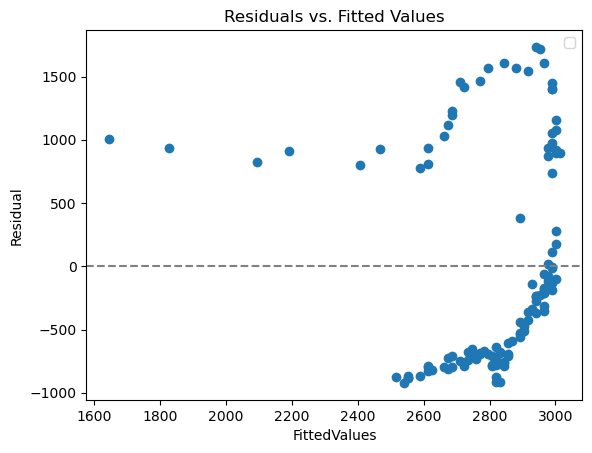

In [18]:
y_residual1 = model1.resid

fig, ax = plt.subplots()
ax.scatter(y_fit1, y_residual1)
ax.legend()
ax.set_xlabel('FittedValues')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

<b>Comment: </b>There is a cone shaped pattern in the residuals by fitted value plot, suggesting heteroskedaticity. 

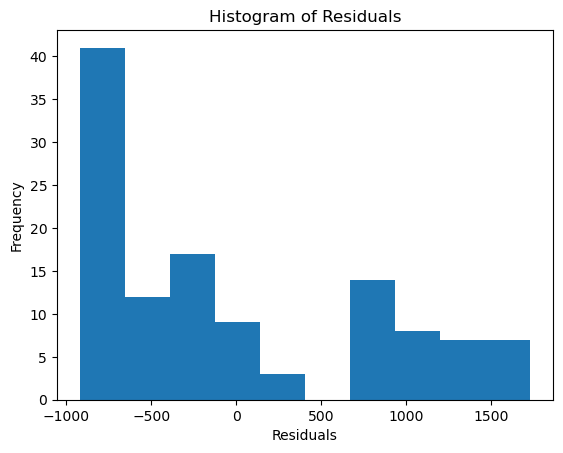

In [19]:
plt.hist(y_residual1, bins=10)

# Add axis labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Show the plot
plt.show()

<b>Comment: </b>The residual histogram shows that most residuals are smaller than zero. This means the fitted values are often smaller than actual values. There is also a decay in residuals' frequency. 

#### (d) Periodic Model

In [20]:
X1_sq = data['UNRATE']**2
X1 = data['UNRATE']
X2 = data['UNRATE'].shift(-1)
y = data['SP500']
model2 = smf.ols('y ~ X1  + X2 + X1_sq', data = data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     15.02
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           0.000177
Time:                        12:30:24   Log-Likelihood:                -957.94
No. Observations:                 118   AIC:                             1920.
Df Residuals:                     116   BIC:                             1925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4411.0851    421.359     10.469      0.0

<b>Comment: </b><br> 1. By adding a leading term the R-squared result(13.8%) suggests the model is a better overall fit. <br>2. The p-value for F-statistic in this model is 0.0007, suggesting that this model is strongly statistically significant.<br> 3. P-value for the t-test of the model parameters shows that the model is statistically significant as well except for the quatratic term.

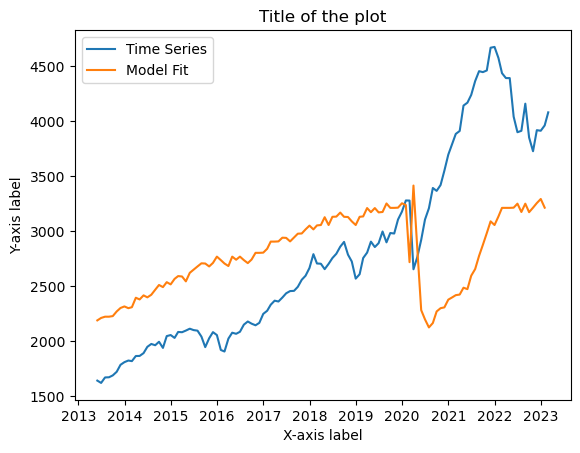

In [21]:
y_fit2 = model2.fittedvalues

fig, ax = plt.subplots()
ax.plot(data.index, data['SP500'], label='Time Series')
ax.plot(data.index.drop('2023-02-28'), y_fit2, label='Model Fit')
ax.legend()
ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
ax.set_title('Title of the plot')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


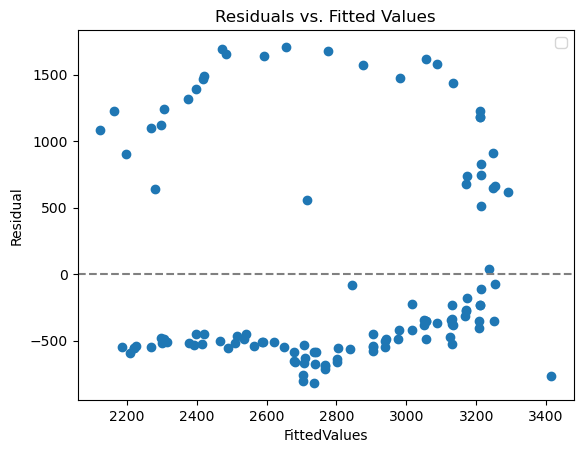

In [24]:
y_residual2 = model2.resid

fig, ax = plt.subplots()
ax.scatter(y_fit2, y_residual2)
ax.legend()
ax.set_xlabel('FittedValues')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

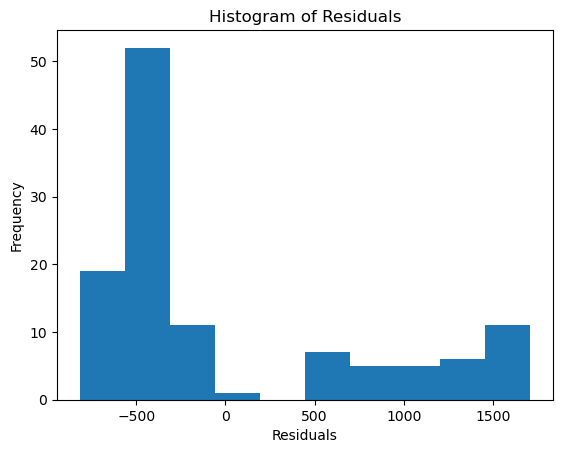

In [25]:
plt.hist(y_residual2, bins=10)

# Add axis labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Show the plot
plt.show()

#### (e) AIC and BIC

In [26]:
print("Model 1:")
print("AIC:", model1.aic)
print("BIC:", model1.bic)

print("Model 2:")
print("AIC:", model2.aic)
print("BIC:", model2.bic)

Model 1:
AIC: 1926.3271261922498
BIC: 1931.868495441181
Model 2:
AIC: 1899.910610231475
BIC: 1910.959305970666


<b>Comment: </b>Results shows that Model 2 has better performance comparing to Model 1 with lower AIC and BIC scores

#### (f) 12 Steps Forecast

In [ ]:
x_forecast = np.arange(101, 113)

# make predictions for h-steps ahead
y_forecast = model.predict(sm.add_constant(x_forecast))

# calculate uncertainty prediction interval
se = np.sqrt(model.mse_resid)
alpha = 0.05  # significance level
t = sm.stats.t.ppf(1 - alpha/2, model.df_resid)
lower_ci = y_forecast - t * se
upper_ci = y_forecast + t * se

# print predictions and uncertainty interval
print("Predictions for next 12 steps:")
print(y_forecast)
print("Uncertainty prediction interval (95% CI):")
print(lower_ci, upper_ci)

### 2. Trend and Seansonal Adjustments